In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("notebook")


In [10]:
files = [
    "api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv"
]

dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)


In [11]:
df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213.0,49.0,529.0
1,01-03-2025,Andhra Pradesh,Chittoor,517132.0,22.0,375.0
2,01-03-2025,Gujarat,Rajkot,360006.0,65.0,765.0
3,01-03-2025,Andhra Pradesh,Srikakulam,532484.0,24.0,314.0
4,01-03-2025,Rajasthan,Udaipur,313801.0,45.0,785.0


In [12]:
df.shape, df.columns

((1020196, 6),
 Index(['date', 'state', 'district', 'pincode', 'demo_age_5_17',
        'demo_age_17_'],
       dtype='object'))

In [13]:
# Robust date parsing:
df['date'] = pd.to_datetime(
    df['date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

# Remove rows missing critical identifiers
df = df.dropna(subset=['date', 'state', 'district', 'pincode'])

In [14]:
df

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213.0,49.0,529.0
1,2025-03-01,Andhra Pradesh,Chittoor,517132.0,22.0,375.0
2,2025-03-01,Gujarat,Rajkot,360006.0,65.0,765.0
3,2025-03-01,Andhra Pradesh,Srikakulam,532484.0,24.0,314.0
4,2025-03-01,Rajasthan,Udaipur,313801.0,45.0,785.0
...,...,...,...,...,...,...
1020191,2025-12-29,West Bengal,West Midnapore,721212.0,0.0,12.0
1020192,2025-12-29,West Bengal,West Midnapore,721420.0,0.0,1.0
1020193,2025-12-29,West Bengal,West Midnapore,721424.0,0.0,5.0
1020194,2025-12-29,West Bengal,West Midnapore,721426.0,0.0,3.0


Minimal State Normalization

In [15]:
import re
# Function to standardize state names
def clean_state(x):
    x = str(x).lower()
    x = re.sub(r'[^a-z\s]', ' ', x)
    x = re.sub(r'\s+', ' ', x).strip()
    return x

# Apply cleaning
df['state_clean'] = df['state'].apply(clean_state)

# Correct common known variants
state_map = {
    # Legacy / alternate spellings
    'orissa': 'Odisha',
    'pondicherry': 'Puducherry',
    'uttaranchal': 'Uttarakhand',
    'tamilnadu': 'Tamil Nadu',

    # West Bengal variants (important)
    'west bengli': 'West Bengal',
    'west bangal': 'West Bengal',
    'westbengal': 'West Bengal',
    'west bengal': 'West Bengal',
    'Westbengal' : 'West Bengal',
    'West Bangal' : 'West Bengal',


    'andaman and Nicobar Islands' : 'Andaman and Nicobar Islands',
    'andaman & Nicobar Islands' : 'Andaman and Nicobar Islands',

    'Dadra and Nagar Haveli' : 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra and Nagar Haveli and Daman and Diu' : 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman and Diu' : 'Dadra and Nagar Haveli and Daman and Diu',

    'Daman & Diu' : 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra & Nagar Haveli' : 'Dadra and Nagar Haveli and Daman and Diu',

    'The Dadra and Nagar Haveli and Daman and Diu	' : 'Dadra and Nagar Haveli and Daman and Diu',


}

df['state_clean'] = df['state_clean'].replace(state_map)
df['state_clean'] = df['state_clean'].str.title()

# Remove invalid numeric state entries
df = df[~df['state_clean'].str.isnumeric()]

Feature Engineering

In [16]:
# Total demographic updates per record
df['total_updates'] = (
    df['demo_age_5_17'] +
    df['demo_age_17_']
)

# Share of updates performed by youth (age 5–17)
df['youth_update_ratio'] = (
    df['demo_age_5_17'] / df['total_updates']
)

# Share of updates performed by adults (age 18+)
df['adult_update_ratio'] = (
    df['demo_age_17_'] / df['total_updates']
)


In [17]:
df

,date,state,district,pincode,demo_age_5_17,demo_age_17_,state_clean,total_updates,youth_update_ratio,adult_update_ratio
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213.0,49.0,529.0,Uttar Pradesh,578.0,0.084775,0.915225
1,2025-03-01,Andhra Pradesh,Chittoor,517132.0,22.0,375.0,Andhra Pradesh,397.0,0.055416,0.944584
2,2025-03-01,Gujarat,Rajkot,360006.0,65.0,765.0,Gujarat,830.0,0.078313,0.921687
3,2025-03-01,Andhra Pradesh,Srikakulam,532484.0,24.0,314.0,Andhra Pradesh,338.0,0.071006,0.928994
4,2025-03-01,Rajasthan,Udaipur,313801.0,45.0,785.0,Rajasthan,830.0,0.054217,0.945783
...,...,...,...,...,...,...,...,...,...,...
1020191,2025-12-29,West Bengal,West Midnapore,721212.0,0.0,12.0,West Bengal,12.0,0.000000,1.000000
1020192,2025-12-29,West Bengal,West Midnapore,721420.0,0.0,1.0,West Bengal,1.0,0.000000,1.000000
1020193,2025-12-29,West Bengal,West Midnapore,721424.0,0.0,5.0,West Bengal,5.0,0.000000,1.000000
1020194,2025-12-29,West Bengal,West Midnapore,721426.0,0.0,3.0,West Bengal,3.0,0.000000,1.000000


In [18]:
df.drop(columns = ['state'], inplace = True)


In [19]:
df

,date,district,pincode,demo_age_5_17,demo_age_17_,state_clean,total_updates,youth_update_ratio,adult_update_ratio
0,2025-03-01,Gorakhpur,273213.0,49.0,529.0,Uttar Pradesh,578.0,0.084775,0.915225
1,2025-03-01,Chittoor,517132.0,22.0,375.0,Andhra Pradesh,397.0,0.055416,0.944584
2,2025-03-01,Rajkot,360006.0,65.0,765.0,Gujarat,830.0,0.078313,0.921687
3,2025-03-01,Srikakulam,532484.0,24.0,314.0,Andhra Pradesh,338.0,0.071006,0.928994
4,2025-03-01,Udaipur,313801.0,45.0,785.0,Rajasthan,830.0,0.054217,0.945783
...,...,...,...,...,...,...,...,...,...
1020191,2025-12-29,West Midnapore,721212.0,0.0,12.0,West Bengal,12.0,0.000000,1.000000
1020192,2025-12-29,West Midnapore,721420.0,0.0,1.0,West Bengal,1.0,0.000000,1.000000
1020193,2025-12-29,West Midnapore,721424.0,0.0,5.0,West Bengal,5.0,0.000000,1.000000
1020194,2025-12-29,West Midnapore,721426.0,0.0,3.0,West Bengal,3.0,0.000000,1.000000


Demographic Update Intensity (Identity Churn)

In [20]:
# Aggregate demographic update behaviour at state level
state_updates = (
    df.groupby('state_clean')
      .agg(
          total_updates=('total_updates', 'sum'),
          avg_updates_per_record=('total_updates', 'mean')
      )
      .sort_values('avg_updates_per_record', ascending=False)
)

state_updates.head()


,total_updates,avg_updates_per_record
state_clean,,
Delhi,622081.0,118.378877
Chhattisgarh,950060.0,53.470284
Uttar Pradesh,3959306.0,48.892997
Bihar,2250426.0,47.053464
Manipur,150278.0,41.104486


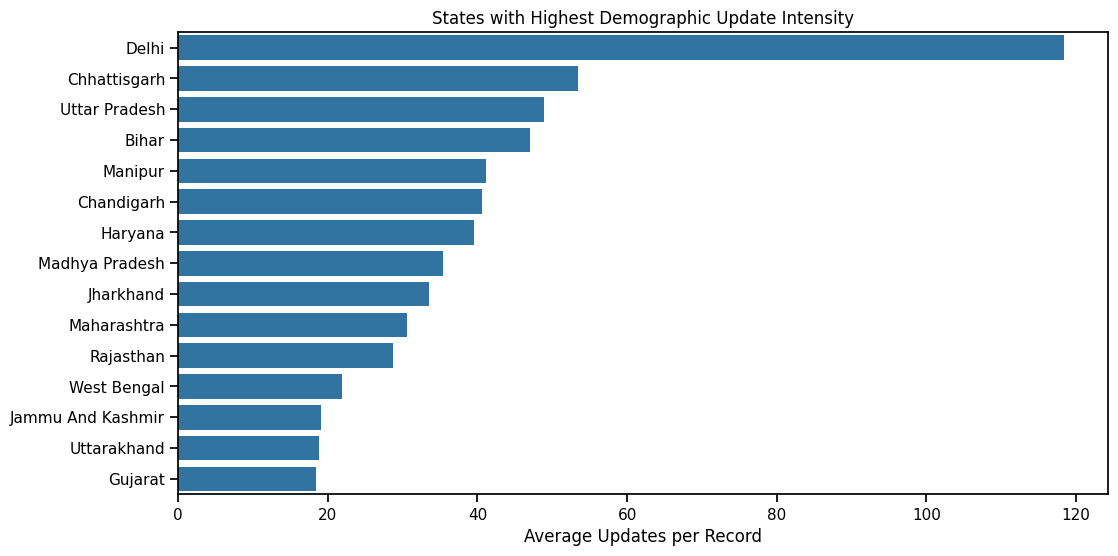

In [21]:
# Visualizing states with the highest demographic update intensity
plt.figure(figsize=(12,6))
sns.barplot(
    data=state_updates.reset_index().head(15),
    x='avg_updates_per_record',
    y='state_clean'
)
plt.title("States with Highest Demographic Update Intensity")
plt.xlabel("Average Updates per Record")
plt.ylabel("")
plt.show()


Youth vs Adult Update Behaviour/Age-Based Update Composition

In [22]:
# Compare youth vs adult contribution to demographic updates
state_age_mix = (
    df.groupby('state_clean')
      .agg(
          youth_ratio=('youth_update_ratio', 'mean'),
          adult_ratio=('adult_update_ratio', 'mean')
      )
      .sort_values('adult_ratio', ascending=False)
)

state_age_mix.head()


,youth_ratio,adult_ratio
state_clean,,
,0.0,1.0
Chhatisgarh,0.0,1.0
Darbhanga,0.0,1.0
Balanagar,0.0,1.0
Madanapalle,0.0,1.0


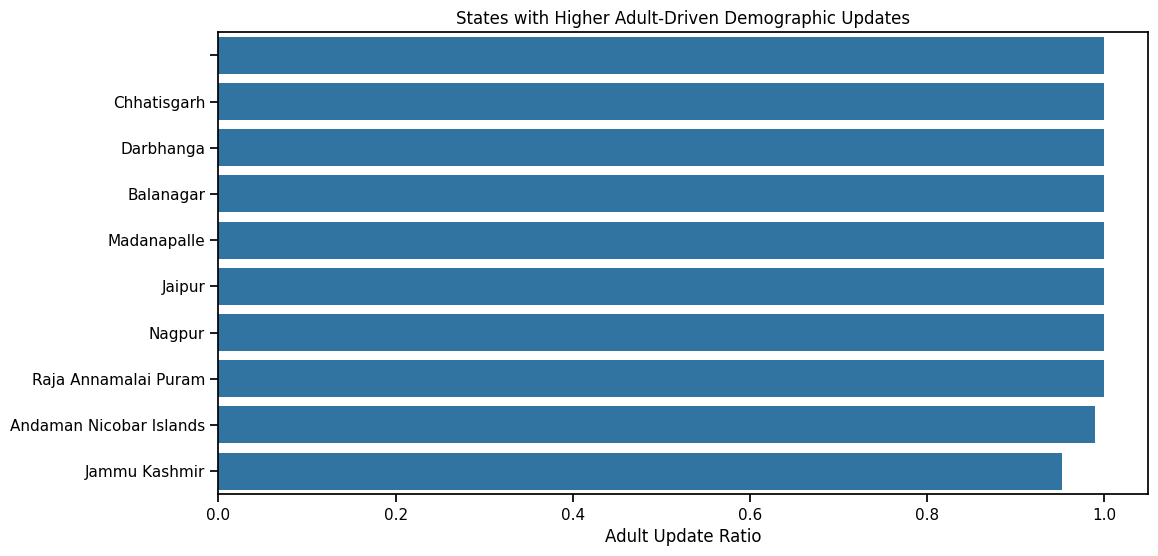

In [23]:
# Visualizing states where adult-driven updates dominate
plt.figure(figsize=(12,6))
sns.barplot(
    data=state_age_mix.reset_index().head(10),
    x='adult_ratio',
    y='state_clean'
)
plt.title("States with Higher Adult-Driven Demographic Updates")
plt.xlabel("Adult Update Ratio")
plt.ylabel("")
plt.show()


In [24]:
# Export key demographic metrics for cross-dataset analysis

demographic_export = state_updates.reset_index()[[
    'state_clean',
    'avg_updates_per_record'
]]

demographic_export = demographic_export.merge(
    state_age_mix.reset_index()[['state_clean', 'adult_ratio']],
    on='state_clean'
)

demographic_export.rename(
    columns={'adult_ratio': 'adult_update_ratio'},
    inplace=True
)

demographic_export.to_csv(
    "demographic_state_metrics.csv",
    index=False
)

demographic_export.head()


,state_clean,avg_updates_per_record,adult_update_ratio
0,Delhi,118.378877,0.903655
1,Chhattisgarh,53.470284,0.889819
2,Uttar Pradesh,48.892997,0.896919
3,Bihar,47.053464,0.912416
4,Manipur,41.104486,0.814771


Temporal Spikes in Demographic Updates/Daily Update Aggregation

In [25]:
# Aggregate demographic updates at daily level
daily_updates = (
    df.groupby(['state_clean', 'date'])
      ['total_updates']
      .sum()
      .reset_index()
)


Time-Series Shock Analysis

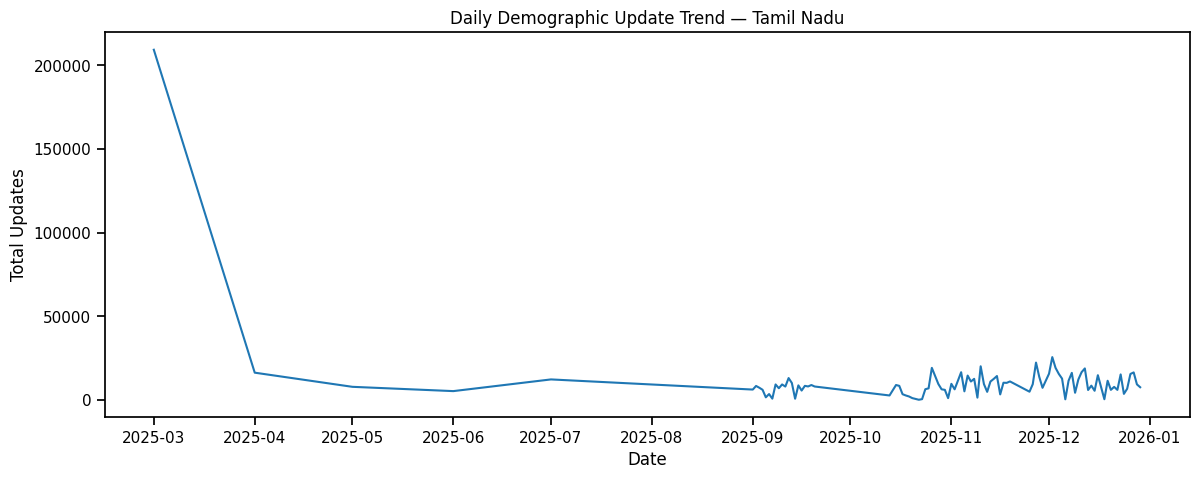

In [26]:
# Example state for temporal analysis
example_state = "Tamil Nadu"

plt.figure(figsize=(14,5))
sns.lineplot(
    data=daily_updates[daily_updates['state_clean'] == example_state],
    x='date',
    y='total_updates'
)
plt.title(f"Daily Demographic Update Trend — {example_state}")
plt.xlabel("Date")
plt.ylabel("Total Updates")
plt.show()
